In [49]:
import pandas as pd
import sys
import numpy as np
import string
import os
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score

	

from xgboost import XGBRegressor, XGBClassifier

In [2]:
os.path.abspath('..')
sys.path.append(os.path.abspath('..'))


In [94]:
import importlib

import transformers
from transformers.columns_setter_transformer import ColumnsSetterTransformer
from transformers.extract_set_column_transformer import ExtractSetColumnsTransformer
from transformers.select_transformer import SelectTransformer
from transformers.select_by_index_transformer import SelectByIndexTransformer
from transformers.one_hot_encoder_transformer import OneHotEncoderTransformer
from transformers.select_by_mask_transformer import SelectByMaskTransformer
from transformers.my_turns_transformation import MyTurnsTransformation
from transformers.classify_set_transformer import ClassifySetTransformer
importlib.reload(transformers)
importlib.reload(transformers.columns_setter_transformer)
importlib.reload(transformers.extract_set_column_transformer)
importlib.reload(transformers.select_transformer)
importlib.reload(transformers.select_by_index_transformer)
importlib.reload(transformers.one_hot_encoder_transformer)
importlib.reload(transformers.select_by_mask_transformer)
importlib.reload(transformers.my_turns_transformation)
importlib.reload(transformers.classify_set_transformer)



import functions
from functions.is_bot_extractor import IsBotExtarctor
importlib.reload(functions)
importlib.reload(functions.is_bot_extractor)

import builders
from builders.preprocessor_builder import PreprocessorBuilder
importlib.reload(builders)
importlib.reload(builders.preprocessor_builder)

import searcher
import searcher_results_orgenizer
from searcher_results_orgenizer import SearcherResultsOrgenizer
importlib.reload(searcher)
importlib.reload(searcher_results_orgenizer)







<module 'searcher_results_orgenizer' from 'c:\\Users\\Bina4\\Desktop\\Guy_hafifa\\scrabble\\searcher_results_orgenizer.py'>

In [4]:
games = pd.read_csv('../data/games.csv', index_col='game_id')
train = pd.read_csv('../data/train.csv', index_col='game_id')
turns = pd.read_csv('../data/turns.csv', index_col='game_id')


In [5]:
G_NAME = 'games'
T_NAME = 'turns'
DATA_NAME = 'train'

names = ['BetterBot', 'STEEBot', 'HastyBot']

features = np.load('../feature_selection_consts/columns.npy', allow_pickle=True)


prePipe = Pipeline([
                    ('get_relavent_turns', SelectByIndexTransformer(train.index.unique(), target=T_NAME)),
                     ('get_relavent_games',  SelectByIndexTransformer(train.index.unique(), target=G_NAME)),
                     ('train_set_is_player', ExtractSetColumnsTransformer({'is_player': IsBotExtarctor(names, 'nickname', True)},
                                                                           src=DATA_NAME, dest=DATA_NAME)),
                     ('get_bot_rating', ExtractSetColumnsTransformer({'bot_rating': lambda train: train[~train['is_player']]['rating']},
                                                                      src=DATA_NAME, dest=G_NAME)),
                     ('get_bots_names', ExtractSetColumnsTransformer({'bot_name': lambda train: train[~train['is_player']]['nickname']},
                                                                     src=DATA_NAME, dest=G_NAME)),
                    ('data_drop_bot_rating', SelectByMaskTransformer('is_player', target=DATA_NAME)),
                    ])
preprocessor = PreprocessorBuilder(games, G_NAME, turns, T_NAME, prePipe).build()
n_games, n_turns, n_ratings = preprocessor.process(train, DATA_NAME)
t_turns = pd.read_csv('../data/fs_turns.csv', index_col='game_id') # MyTurnsTransformation().transform(n_turns)
n_data = n_games.merge(t_turns, left_index=True, right_index=True)



In [6]:
regressor_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('xgb', XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]

regressor = Pipeline(regressor_steps)
regressor.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x00000263E4106C70>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [7]:
prediction = pd.Series(regressor.predict(n_data), index=n_ratings.index)

In [8]:
mean_squared_error(n_ratings, prediction, squared=False)

87.01702826366557

In [9]:
abs_error = np.abs(prediction - n_ratings)

In [10]:
abs_error.describe()

count    50410.000000
mean        59.767238
std         63.244919
min          0.000244
25%         12.078369
50%         40.841003
75%         86.747253
max        608.116089
dtype: float64

In [11]:
prediction.describe()

count    50410.000000
mean      1790.332886
std        204.806305
min       1058.774292
25%       1614.981903
50%       1816.444092
75%       1975.551117
max       2463.072510
dtype: float64

In [12]:
n_ratings.describe()

count    50410.000000
mean      1790.322674
std        229.662441
min       1033.000000
25%       1582.000000
50%       1818.000000
75%       1982.000000
max       2510.000000
Name: rating, dtype: float64

<Axes: >

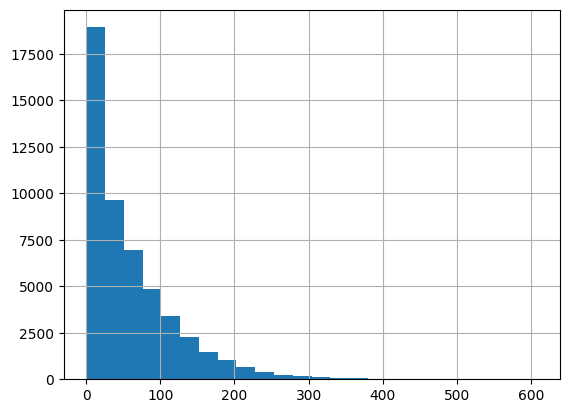

In [13]:
abs_error.hist(bins=24)

In [14]:
(abs_error < 100).sum() / abs_error.size

0.7974608212656219

In [15]:
(abs_error > 200).sum()

1936

In [16]:
n_games[abs_error>200].describe()

,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,bot_rating
count,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000
mean,0.316632,1204.927686,0.138430,1.133264,584.096847,2031.152893
std,0.471900,530.680899,2.732038,1.009418,281.676558,145.393588
min,-1.000000,180.000000,0.000000,0.000000,120.440364,1594.000000
25%,0.000000,960.000000,0.000000,1.000000,378.638119,1956.000000
50%,0.000000,1200.000000,0.000000,1.000000,521.300345,2033.000000
75%,1.000000,1200.000000,0.000000,1.000000,741.078766,2137.000000
max,1.000000,3600.000000,60.000000,10.000000,2087.298744,2341.000000


In [17]:
(n_ratings < 1600).astype(int)

game_id
1        1
3        0
4        1
5        1
6        0
        ..
72767    1
72770    1
72771    1
72772    1
72773    0
Name: rating, Length: 50410, dtype: int32

In [18]:
n_data

,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,...,p_.__median,p_move_len__mean,p_move_len__root_mean_square,p_jokers_num__sum_values,p_jokers_num__mean,b_turn_type_End__mean,b_e__standard_deviation,b_l__mean,b_move_len__sum_values,b_jokers_num__mean
game_id,,,,,,,,,,,,,,,,,,,,,
1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,...,0.0,3.857143,4.191829,2.0,0.142857,0.000000,0.000000,0.0,60.0,0.000000
3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,...,0.0,4.357143,4.652188,1.0,0.071429,0.000000,0.000000,0.0,57.0,0.076923
4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,...,1.0,2.928571,3.218252,0.0,0.000000,0.000000,0.000000,0.0,76.0,0.066667
5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,...,0.0,3.375000,3.553168,0.0,0.000000,0.000000,0.249444,0.0,67.0,0.133333
6,HivinD,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,...,0.5,4.750000,4.804512,0.0,0.000000,0.076923,0.000000,0.0,66.0,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72767,BetterBot,regular,TIME,0,2022-09-05 04:35:56,CSW21,3600,0,CASUAL,1,...,0.0,3.500000,3.840573,1.0,0.062500,0.000000,0.000000,0.0,73.0,0.062500
72770,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,...,1.0,3.187500,3.363406,1.0,0.062500,0.000000,0.242061,0.0,79.0,0.062500
72771,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,...,1.0,4.250000,4.527693,0.0,0.000000,0.000000,0.000000,0.0,59.0,0.133333


In [100]:
classifier_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('xgb', XGBClassifier(random_state=0,)),                                              
                   ]

classifer = Pipeline(classifier_steps)

train_x, _, train_y, _ = train_test_split(n_data, n_ratings, test_size=0.99, random_state=42)

classifer.fit(train_x, (train_y < 1600).astype(int))

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x0000026389BD6250>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [101]:
c_pred = classifer.predict(n_data)
accuracy_score(c_pred, n_ratings < 1600)

0.8816901408450705

In [54]:
classifer[-1]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [97]:
new_regressor_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('xgb1', ClassifySetTransformer(XGBClassifier(random_state=0), 'bigger', prefit=False)),
                   ('xgb2', XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]

new_regressor = Pipeline(new_regressor_steps)
new_regressor.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002638A340DC0>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [65]:
new_prediction = new_regressor.predict(n_data)

In [66]:
mean_squared_error(n_ratings, new_prediction, squared=False)

85.11115019914347

In [103]:
cv_res = cross_validate(new_regressor, n_data, n_ratings, cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [105]:
pd.DataFrame(cv_res).mean()

fit_time         3.988106
score_time       0.124936
test_score    -105.746466
train_score    -85.052642
dtype: float64